Load required libraries

In [8]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt

Examples of linear regression estimators

In [3]:
# OLS estimates of log(wage) ~ education, experience regression
# Data from US Current population survey, 1985

df = sm.datasets.get_rdataset("CPS1985", package="AER").data
res = smf.ols("np.log(wage) ~ education + experience + np.power(experience, 2)", df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     55.23
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           4.46e-31
Time:                        16:15:01   Log-Likelihood:                -343.28
No. Observations:                 534   AIC:                             694.6
Df Residuals:                     530   BIC:                             711.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.5203      0.124      4.209      0.000       0.277       0.763
education                   0.0898      0.008     10.787      0.000       0.073       0.106
experience                  0.0349      0.006      6.185      0.000       0.024       0.046
np.power(experience, 2)    -0.0005      0.000     -4.307      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        9.391   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.363
Skew:                          -0.037   Prob(JB):                     0.000461
Kurtosis:                       3.828   Cond. No.                     4.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
# The above uses statsmodels, a convenient Python package for statistics
# We will use statsmodels frequently in this class
# Here we check it gives the same estimates as our OLS formula:

data = smf.ols("np.log(wage) ~ education + experience + np.power(experience, 2)", df).data
y, X = data.endog, data.exog
beta_hat = np.linalg.solve(X.T @ X, X.T @ y)
beta_hat

array([ 0.52032177,  0.08975608,  0.03494034, -0.00053624])

In [62]:
# Lets predict the log(wage) for some one with
# 8 years of education and 4 years of experience

np.array([1, 8, 4, 16]) @ beta_hat 

1.3695519429791423

In [75]:
# Or via statsmodels
X_new = pd.DataFrame({'education': [8], 'experience' : [4]})
res.predict(exog = X_new)

0    1.369552
dtype: float64

In [87]:
# We'll now show that the same estimate for $\beta_1$ 
# is achieved if we first use the Frisch -- Waugh -- Lovell
# Theorem to "partial out" the rest of the covariates

X1 = X[:, 1]
X2 = X[:, [0, 2, 3]]
P2 = X2 @ np.linalg.solve(X2.T @ X2, X2.T)
M2 = np.eye(P2.shape[0]) - P2

(X1.T @ M2 @ y) / (X1.T @ M2 @ X1)

0.08975608205864281

In [9]:
# Estimation of error variance

# From statsmodels, this is stored as scale in the results object
print(res.scale)

# By "hand":
e = y - X @ beta_hat
(e.T @ e) / (e.shape[0] - X.shape[1])


0.21338183931211507


0.2133818393121151

In [15]:
# FWLS -- Statsmodels

mod_wls = smf.wls("np.log(wage) ~ education + experience + np.power(experience, 2)",
         weights = 1 / res.resid**2, data = df)
res_wls = mod_wls.fit()
res_wls.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.973
Model:                            WLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     6256.
Date:                Sun, 27 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:39:10   Log-Likelihood:                -7.5881
No. Observations:                 534   AIC:                             23.18
Df Residuals:                     530   BIC:                             40.30
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.5204      0.014     36.182      0.000       0.492       0.549
education                   0.0894      0.001     89.462      0.000       0.087       0.091
experience                  0.0355      0.000     75.611      0.000       0.035       0.036
np.power(experience, 2)    -0.0005   1.35e-05    -40.598      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     2204.095   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.834
Skew:                          -0.030   Prob(JB):                     8.45e-20
Kurtosis:                       1.014   Cond. No.                     5.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
# FWLS -- by "hand"

e = y - X @ beta_hat
C = np.diag(1 / np.sqrt(e**2))
Cy = C @ y
CX = C @ X

beta_tilde = np.linalg.solve(CX.T @ CX, CX.T @ Cy)
beta_tilde


array([ 0.52039612,  0.08941247,  0.03549268, -0.00054882])

In [56]:
# Aitken's Theorem illustration

def sample(n, V):
    X = np.random.standard_t(8, n)
    u = np.random.standard_normal(n)
    e = V * u
    y = X + e
    return(y.reshape(n, 1), X.reshape(n, 1))

def gen_V(n):
    return(0.1 + np.sin(2 * np.arange(1, n + 1) / n))

def ols(y, X):
    return np.linalg.solve(X.T @ X, X.T @ y)

def wls(y, X, C):
    return ols(C @ y, C @ X)

def fwls(y, X, beta_hat):
    e = y - X @ beta_hat
    C = np.diag((1 / np.sqrt(e**2)).flatten())
    return wls(y, X, C)


M = 5000
ns = [100, 500, 1000]
out = np.zeros((M, 3, 3))
np.random.seed(452)

for (j , n) in enumerate(ns):
    
    V = gen_V(n)
    C = np.diag(1 / np.sqrt(V))

    for m in range(M):

        # Sample data
        y, X = sample(n, V)

        # OLS 
        beta_hat = ols(y, X)
        out[m, 0, j] = beta_hat

        # WLS 
        out[m, 1, j] = wls(y, X, C)

        # FWLS
        out[m, 2, j] = fwls(y, X, beta_hat)


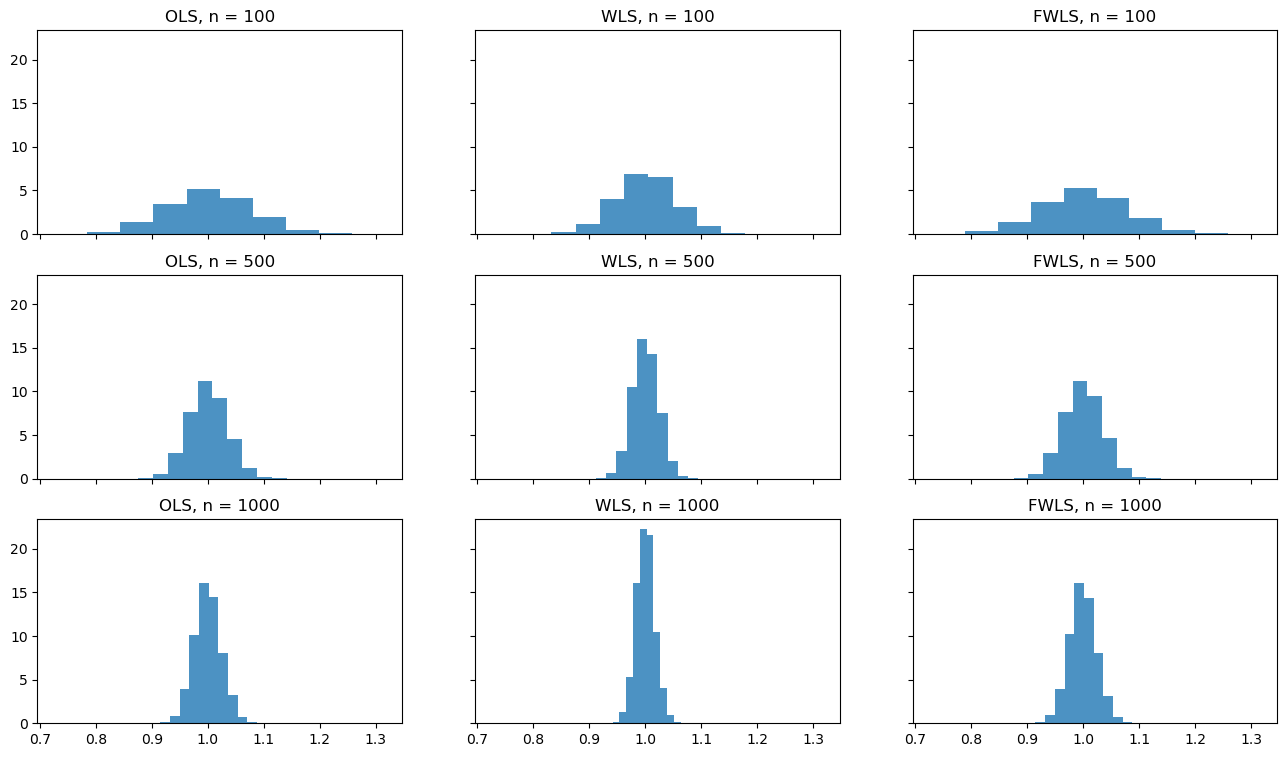

In [70]:
# Lets plot histograms of the estimates:

estimators = ["OLS", "WLS", "FWLS"]
sample_size = ["n = 100", "n = 500", "n = 1000"]

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize = (16, 9))

for j in range(3):
    for i in range(3):
        axes[j, i].hist(out[:, i, j],
                         density = True,
                           alpha = 0.8)
        axes[j, i].set_title(estimators[i] + ", " + sample_size[j])

# fig.savefig("../figures/output/aitken.pdf")

In [78]:
# The histogram reveals that the FWLS estimator is more tightly centered around the truth
# All seem to be unbiased (as they should be)
# We also get much better estimates for each estimator when the sample size is larger
# The FWLS estimator and OLS estimator don't show much difference.

var = pd.DataFrame([[np.mean((out[:, i, j] - 1)**2) for i in range(3)] for j in range(3)],
              columns=estimators)
var.insert(0, "n", ns)
var.set_index("n", inplace=True)
var

# var.style.to_latex("../figures/output/aitken.tex", hrules=True)

# Here again we see a substantial reduction when the variances are known 
# ...but only a slight improvement for feasible WLS. 